In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,ConfusionMatrixDisplay
import pybaseball
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


In [2]:
pybaseball.cache.enable()

In [3]:
data = pybaseball.statcast(start_dt = "2023-06-13", end_dt = "2025-05-05")

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 454/454 [01:38<00:00,  4.62it/s]
c:\Users\eSports\AppData\Local\Programs\Python\Python312\Lib\site-packages\pybaseball\statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


In [4]:
filtered_data = data[["pitcher","batter","description","zone","p_throws","launch_speed","launch_angle","release_spin_rate","release_speed","release_pos_x","release_pos_z","hit_location","plate_x","plate_z"]]

In [5]:
filtered_data = filtered_data.fillna(0)
filtered_data.head()

,pitcher,batter,description,zone,p_throws,launch_speed,launch_angle,release_spin_rate,release_speed,release_pos_x,release_pos_z,hit_location,plate_x,plate_z
1465,660853,668715,hit_into_play,6,R,77.7,4,2116,88.1,-2.22,5.49,6,0.61,2.2
1486,660853,668715,ball,14,R,0.0,0,2218,97.1,-2.02,5.53,0,1.54,2.03
1568,660853,666158,ball,13,R,0.0,0,2212,97.0,-1.99,5.55,0,-0.43,1.3
1583,660853,666158,foul,3,R,54.0,77,2162,96.0,-1.81,5.68,0,0.81,2.84
1630,660853,666158,foul,5,R,30.9,-30,1827,86.1,-1.87,5.77,0,-0.09,2.68


In [6]:
le = LabelEncoder()
filtered_data["p_throws"] = le.fit_transform(filtered_data["p_throws"])
filtered_data["description"] = le.fit_transform(filtered_data["description"])

In [7]:
#Get name mappings
le_name_mapping = dict(zip(le.classes_,le.transform(le.classes_)))
print(le_name_mapping)

{'ball': 0, 'blocked_ball': 1, 'bunt_foul_tip': 2, 'called_strike': 3, 'foul': 4, 'foul_bunt': 5, 'foul_pitchout': 6, 'foul_tip': 7, 'hit_by_pitch': 8, 'hit_into_play': 9, 'intent_ball': 10, 'missed_bunt': 11, 'pitchout': 12, 'swinging_strike': 13, 'swinging_strike_blocked': 14}


In [8]:
y = filtered_data[["description"]]
x = filtered_data.drop("description",axis = 1)

In [9]:
#Attempting to see if PCA on our data set is a good idea before feeding into our model
pca = PCA()
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
pca.fit(x_scaled)
x_pca = pca.transform(x_scaled)

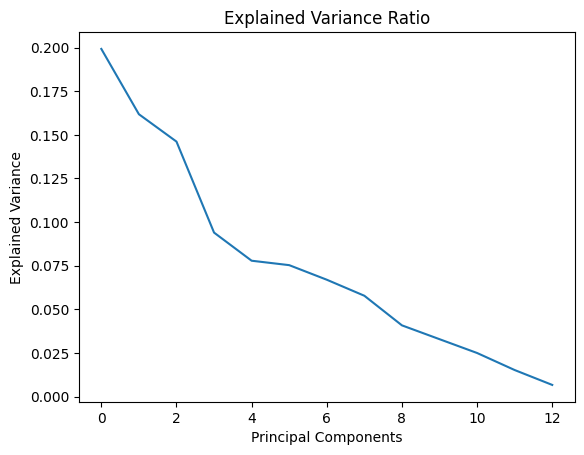

[0.19922867 0.16181386 0.14613316 0.09399688 0.07788119 0.07534736
 0.06699769 0.05781527 0.04085405 0.03293124 0.02501894 0.01525565
 0.00672604]


In [10]:
# Plot
plt.plot(range(0,13), pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.title('Explained Variance Ratio')
plt.show()
print(pca.explained_variance_ratio_)

We can conclude that PCA is not a good fit, we would need almost 10 PCs to have a 95%+ explained variance ratio. Since we only have 10 predictors, PCA was not a good fit for dimension reduction for our data set.

<Axes: >

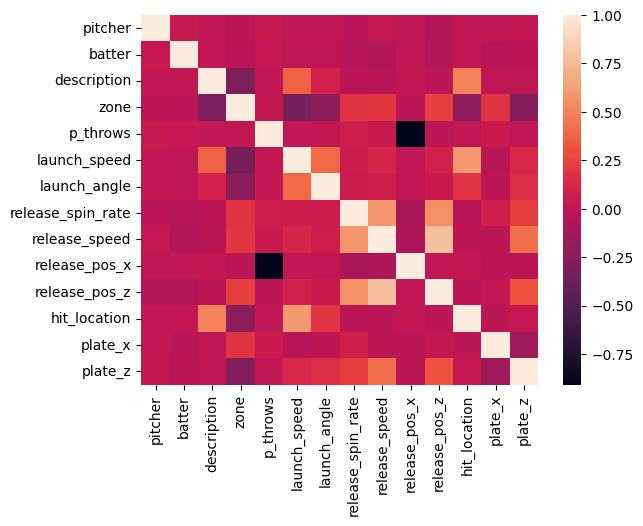

In [11]:
#Plotting Correlation Heatmap 
sns.heatmap(filtered_data.corr())

In [12]:
#Random_state 10
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,shuffle=True)
x_test.shape
x_train.shape

(932079, 13)

In [13]:
#Base Model - This model will be tested against vs models after crossvalidation
base_model = RandomForestClassifier(n_jobs=-1)
base_model.fit(x_train,y_train)
y_pred = base_model.predict(x_test)

c:\Users\eSports\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


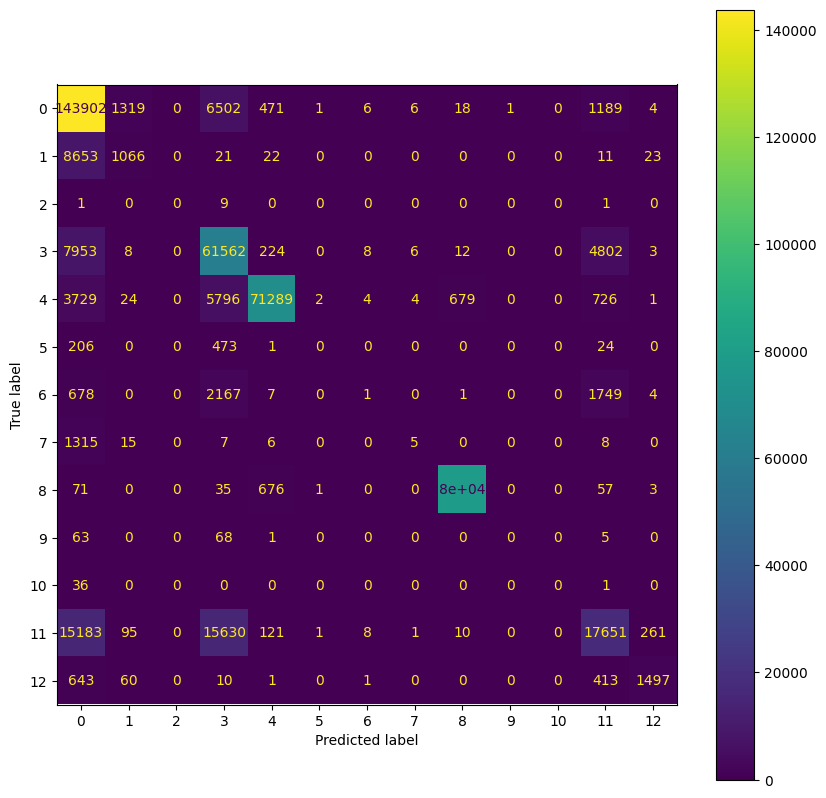

In [14]:
#Make Plots
display_l = filtered_data["description"].values
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix= cm)
fig,ax = plt.subplots(figsize=(10,10))
disp.plot(ax = ax)


In [15]:
#Classification Report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86    182433
           1       0.11      0.41      0.17      2587
           2       0.00      0.00      0.00         0
           3       0.83      0.67      0.74     92280
           4       0.87      0.98      0.92     72819
           5       0.00      0.00      0.00         5
           7       0.00      0.04      0.00        28
           8       0.00      0.23      0.01        22
           9       0.99      0.99      0.99     80476
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.36      0.66      0.47     26637
          14       0.57      0.83      0.68      1796

    accuracy                           0.82    459084
   macro avg       0.36      0.43      0.37    459084
weighted avg       0.87      0.82      0.84    459084



In [16]:
#Feature Importances based on Base Model
importances = base_model.feature_importances_
forest_importances = pd.Series(importances,index = x.columns)
std = np.std([tree.feature_importances_ for tree in base_model.estimators_],axis = 0)


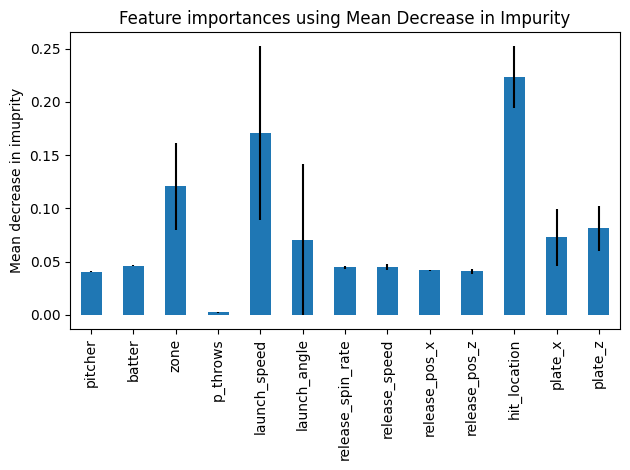

In [17]:
#Feature Importances Plot
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr = std, ax = ax)
ax.set_title("Feature importances using Mean Decrease in Impurity")
ax.set_ylabel("Mean decrease in imuprity")
fig.tight_layout()

In [18]:
#Generating RandomSearchCV Parameter grid
params = {"n_estimators": [50,100,150],
          "max_depth": [None,10,20],
          "min_samples_split": [2,5,10],
          "min_samples_leaf":[1,5,10,15],
          "max_features":["sqrt","log2"]
          }

In [19]:
#use Randomsearch
random_search = RandomizedSearchCV(estimator = RandomForestClassifier(n_jobs = -1), 
                           param_distributions=params,
                           scoring="accuracy",
                           n_jobs = -1,
                           verbose = True,
                           cv = 3,
                           n_iter = 2
                          )

#fitting model
random_search.fit(x_train,y_train)


#Print Results
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

Fitting 3 folds for each of 2 candidates, totalling 6 fits


c:\Users\eSports\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\eSports\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Parameters: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 15, 'max_features': 'sqrt', 'max_depth': 20}
Best Score: 0.8200238391810136


In [20]:
#Select Best Model based on Hyperparameters chosen by randomizedsearch
best_model = RandomForestClassifier(n_estimators=150,
                                    min_samples_split=10,
                                    min_samples_leaf=15,
                                    max_features="log2",
                                    max_depth=20,
                                    n_jobs=-1)
best_model.fit(x_train,y_train)

c:\Users\eSports\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=15,
                       min_samples_split=10, n_estimators=150, n_jobs=-1)

In [21]:
y_pred = best_model.predict(x_test)

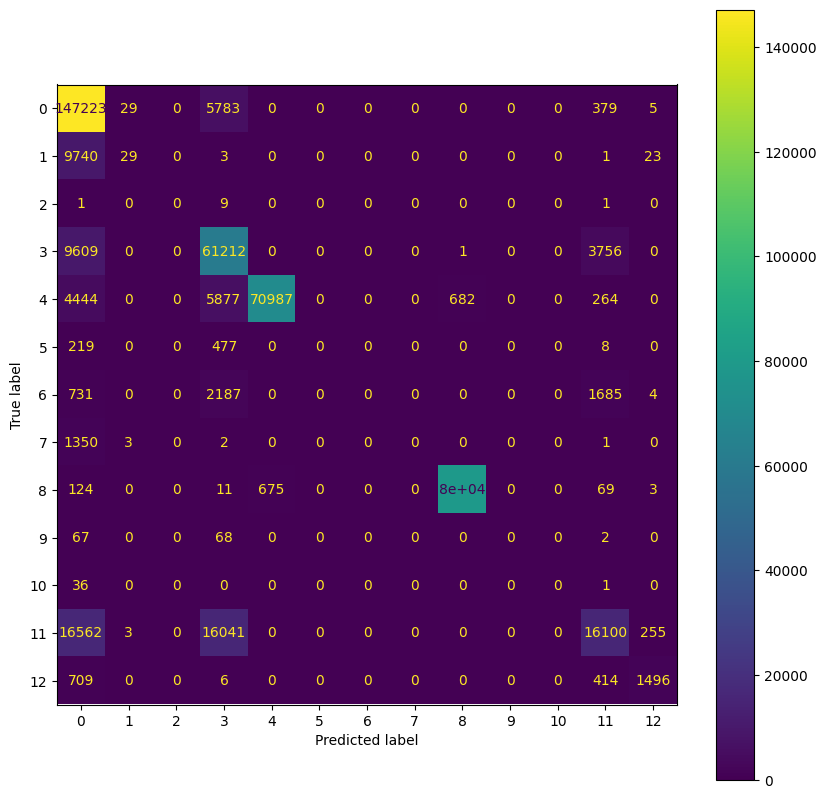

In [22]:
display_l = filtered_data["description"].values
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix= cm)
fig,ax = plt.subplots(figsize=(10,10))
disp.plot(ax = ax)


In [23]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.96      0.77      0.86    190815
           1       0.00      0.45      0.01        64
           2       0.00      0.00      0.00         0
           3       0.82      0.67      0.74     91676
           4       0.86      0.99      0.92     71662
           5       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.99      0.99      0.99     80400
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.33      0.71      0.45     22681
          14       0.57      0.84      0.68      1786

    accuracy                           0.82    459084
   macro avg       0.35      0.42      0.36    459084
weighted avg       0.89      0.82      0.84    459084



In [24]:
importances = best_model.feature_importances_
forest_importances = pd.Series(importances,index = x.columns)
std = np.std([tree.feature_importances_ for tree in best_model.estimators_],axis = 0)

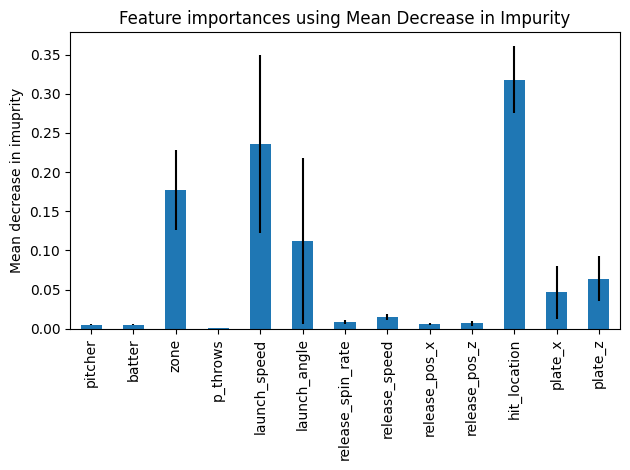

In [25]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr = std, ax = ax)
ax.set_title("Feature importances using Mean Decrease in Impurity")
ax.set_ylabel("Mean decrease in imuprity")
fig.tight_layout()